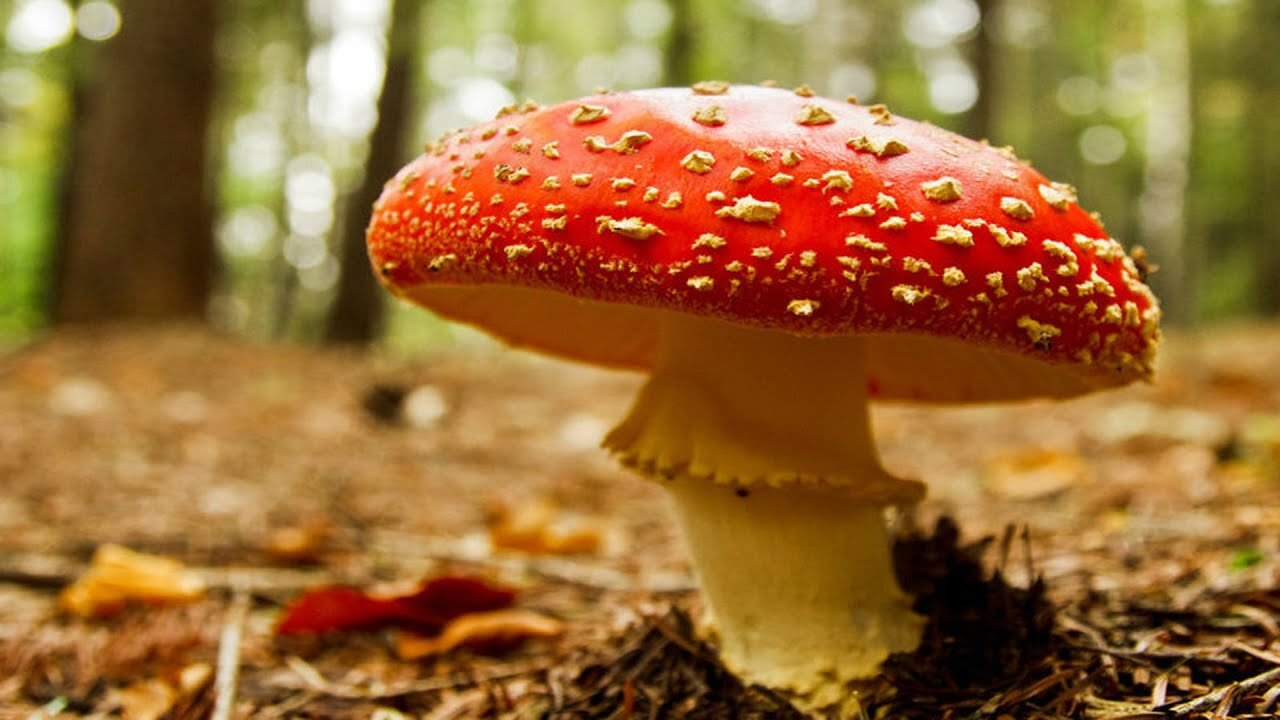

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from scipy.stats import chi2_contingency, f_oneway
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, LabelEncoder,MinMaxScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import matthews_corrcoef


import warnings
warnings.filterwarnings ('ignore')

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
train = train.drop(columns=['id'])

In [3]:
print(f'\033[94mNumber of records (rows) in the dataset are: {train.shape[0]}')
print(f'\033[94mNumber of features (columns) in the dataset are: {train.shape[1]}')
print(f'\033[94mNumber of duplicate entries in the dataset are: {train.duplicated().sum()}')
print(f'\033[94mNumber missing values in the dataset are: {sum(train.isna().sum())}')

Number of records (rows) in the dataset are: 3116945
Number of features (columns) in the dataset are: 21
Number of duplicate entries in the dataset are: 0
Number missing values in the dataset are: 15868508


In [4]:
def get_pretty_frame(train):
    return train.style.set_table_styles(
        [{'selector': 'thead th', 'props': [('background-color', '#3b528b'),
                                            ('color', 'black'),
                                            ('border', '1px solid #dddddd')]},
         {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},
         {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', 'white')]},
         {'selector': 'tbody td', 'props': [('border', '1px solid #dddddd')]}]
    ).set_properties(**{'text-align': 'center'})

In [5]:
get_pretty_frame(train.head())

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.800000,f,s,u,f,a,c,w,4.510000,15.390000,nan,nan,w,nan,nan,f,f,nan,d,a
1,p,4.510000,x,h,o,f,a,c,n,4.790000,6.480000,nan,y,o,nan,nan,t,z,nan,d,w
2,e,6.940000,f,s,b,f,x,c,w,6.850000,9.930000,nan,s,n,nan,nan,f,f,nan,l,w
3,e,3.880000,f,y,g,f,s,nan,g,4.160000,6.530000,nan,nan,w,nan,nan,f,f,nan,d,u
4,e,5.850000,x,l,w,f,d,nan,w,3.370000,8.360000,nan,nan,w,nan,nan,f,f,nan,g,a


In [6]:
table = PrettyTable()
table.field_names = ["Features", "Unique Values"]

for i in train.columns:
    nunique = train[i].nunique()
    table.add_row([i, nunique])

print('Unique values in synthetically generated dataset:\n')
print(table)

Unique values in synthetically generated dataset:

+----------------------+---------------+
|       Features       | Unique Values |
+----------------------+---------------+
|        class         |       2       |
|     cap-diameter     |      3913     |
|      cap-shape       |       74      |
|     cap-surface      |       83      |
|      cap-color       |       78      |
| does-bruise-or-bleed |       26      |
|   gill-attachment    |       78      |
|     gill-spacing     |       48      |
|      gill-color      |       63      |
|     stem-height      |      2749     |
|      stem-width      |      5836     |
|      stem-root       |       38      |
|     stem-surface     |       60      |
|      stem-color      |       59      |
|      veil-type       |       22      |
|      veil-color      |       24      |
|       has-ring       |       23      |
|      ring-type       |       40      |
|  spore-print-color   |       32      |
|       habitat        |       52      |
|     

In [7]:
test = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")

In [8]:
print(f'\033[94mNumber of records (rows) in the dataset are: {test.shape[0]}')
print(f'\033[94mNumber of features (columns) in the dataset are: {test.shape[1]}')
print(f'\033[94mNumber of duplicate entries in the dataset are: {test.duplicated().sum()}')
print(f'\033[94mNumber missing values in the dataset are: {sum(test.isna().sum())}')

Number of records (rows) in the dataset are: 2077964
Number of features (columns) in the dataset are: 21
Number of duplicate entries in the dataset are: 0
Number missing values in the dataset are: 10579477


In [9]:
def get_pretty_frame(test):
    return test.style.set_table_styles(
        [{'selector': 'thead th', 'props': [('background-color', '#3b528b'),
                                            ('color', 'black'),
                                            ('border', '1px solid #dddddd')]},
         {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},
         {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', 'white')]},
         {'selector': 'tbody td', 'props': [('border', '1px solid #dddddd')]}]
    ).set_properties(**{'text-align': 'center'})

In [10]:
get_pretty_frame(test.head())

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.640000,x,nan,n,t,nan,nan,w,11.130000,17.120000,b,nan,w,u,w,t,g,nan,d,a
1,3116946,6.900000,o,t,o,f,nan,c,y,1.270000,10.750000,nan,nan,n,nan,nan,f,f,nan,d,a
2,3116947,2.000000,b,g,n,f,nan,c,n,6.180000,3.140000,nan,nan,n,nan,nan,f,f,nan,d,s
3,3116948,3.470000,x,t,n,f,s,c,n,4.980000,8.510000,nan,nan,w,nan,n,t,z,nan,d,u
4,3116949,6.170000,x,h,y,f,p,nan,y,6.730000,13.700000,nan,nan,y,nan,y,t,nan,nan,d,u


In [11]:
table = PrettyTable()
table.field_names = ["Features", "Unique Values"]

for i in test.columns:
    nunique = test[i].nunique()
    table.add_row([i, nunique])

print('Unique values in synthetically generated dataset:\n')
print(table)

Unique values in synthetically generated dataset:

+----------------------+---------------+
|       Features       | Unique Values |
+----------------------+---------------+
|          id          |    2077964    |
|     cap-diameter     |      3745     |
|      cap-shape       |       62      |
|     cap-surface      |       59      |
|      cap-color       |       57      |
| does-bruise-or-bleed |       22      |
|   gill-attachment    |       66      |
|     gill-spacing     |       35      |
|      gill-color      |       56      |
|     stem-height      |      2664     |
|      stem-width      |      5610     |
|      stem-root       |       31      |
|     stem-surface     |       54      |
|      stem-color      |       55      |
|      veil-type       |       15      |
|      veil-color      |       23      |
|       has-ring       |       23      |
|      ring-type       |       36      |
|  spore-print-color   |       33      |
|       habitat        |       39      |
|     

In [12]:
train = train.drop(columns=['veil-type'])
test = test.drop(columns=['veil-type'])

In [13]:
num_cols = ['cap-diameter', 'stem-height','stem-width']
cat_cols = [i for i in train.columns if train[i].dtype == 'object']
print(cat_cols)

['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


In [14]:
def detect_outliers(df, features):
    outlier_indices = []

    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = list(set(outlier_indices))
    return outlier_indices

outliers = detect_outliers(train, num_cols)
print(f"Number of outliers detected: {len(outliers)}")


train_outliers = train.loc[outliers]
train = train.drop(outliers).reset_index(drop=True)

Number of outliers detected: 228812


In [15]:
num_cols = ['cap-diameter', 'stem-height', 'stem-width']
cat_cols = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color','veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
target = 'class'

X = train.drop(columns=[target])
y = train[target]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ]
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

In [17]:
lgbm_params = {
    'num_leaves': 459, 
    'learning_rate': 0.029054776460531954, 
    'n_estimators': 1188, 
    'subsample_for_bin': 36805,
    'min_child_samples': 180, 
    'reg_alpha': 2.701133349161215, 
    'reg_lambda': 2.3413285519209658e-08, 
    'colsample_bytree': 0.6248142892362624, 
    'subsample': 0.6193856517174553, 
    'max_depth': 11,
    'verbose': -1,
    'device': 'gpu'
}


model_table = pd.DataFrame(columns=['Model Name', 'Score'])

def model_accuracy(model, model_name, X, y, test):
    print('Starting Iteration for', model_name)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    preds = []
    
    for nfold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
        X_fold_train, X_fold_valid = X[train_idx], X[valid_idx]
        y_fold_train, y_fold_valid = y[train_idx], y[valid_idx]
        
        model.fit(X_fold_train, y_fold_train)

        y_pred = model.predict(X_fold_valid)
        mcc = matthews_corrcoef(y_fold_valid, y_pred)
        
        test_preds = model.predict(test)
        
        print(f'Iteration : {nfold + 1}  MCC: {mcc:.5f}')
        
        scores.append(mcc)
        preds.append(test_preds)
        
    i = len(model_table)
    model_table.loc[i, 'Model Name'] = model_name
    model_table.loc[i, 'Score'] = np.mean(scores)
    
    return preds

models = [
    ('LGBMClassifier', LGBMClassifier(random_state=42, **lgbm_params))
]

preds = []
for label, model in models:
    preds = model_accuracy(model, label, X_train_preprocessed, y_train, X_valid_preprocessed)

Starting Iteration for LGBMClassifier


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Iteration : 1  MCC: 0.98373
Iteration : 2  MCC: 0.98346
Iteration : 3  MCC: 0.98334
Iteration : 4  MCC: 0.98360
Iteration : 5  MCC: 0.98324


In [18]:
display(model_table.sort_values(by='Score').style.background_gradient(cmap='summer_r'))

,Model Name,Score
0,LGBMClassifier,0.983474


In [19]:
best_params = {
    'n_estimators': 1396, 
    'max_depth': 19, 
    'learning_rate': 0.010455050159676566, 
    'subsample': 0.8006842727555243, 
    'colsample_bytree': 0.5001438770455072,
    'colsample_bylevel': 0.8027576507794217, 
    'min_child_weight': 5,
    'reg_alpha': 1.1586967014672253e-08, 
    'reg_lambda': 3.3517458803447213e-06,
    'gamma': 0.01841032988451454,
    'tree_method': 'gpu_hist',  
    'predictor': 'gpu_predictor' 
          
}



model_table = pd.DataFrame(columns=['Model Name', 'Score'])

def model_accuracy(model, model_name, X, y, test):
    print('Starting Iteration for', model_name)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    preds = []
    
    for nfold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
        X_fold_train, X_fold_valid = X[train_idx], X[valid_idx]
        y_fold_train, y_fold_valid = y[train_idx], y[valid_idx]
        
    
        model.fit(X_fold_train, y_fold_train)

        y_pred = model.predict(X_fold_valid)
        mcc = matthews_corrcoef(y_fold_valid, y_pred)
        
        test_preds = model.predict(test)
        
        print(f'Iteration : {nfold + 1}  MCC: {mcc:.5f}')
        
        scores.append(mcc)
        preds.append(test_preds)
        
    i = len(model_table)
    model_table.loc[i, 'Model Name'] = model_name
    model_table.loc[i, 'Score'] = np.mean(scores)
    
    return preds

params_xgb = best_params
models = [
    ('XGBClassifier', XGBClassifier(random_state=42, **params_xgb))
]

preds = []
for label, model in models:
    preds = model_accuracy(model, label, X_train_preprocessed, y_train, X_valid_preprocessed)

Starting Iteration for XGBClassifier
Iteration : 1  MCC: 0.98384
Iteration : 2  MCC: 0.98442
Iteration : 3  MCC: 0.98423
Iteration : 4  MCC: 0.98389
Iteration : 5  MCC: 0.98339
Iteration : 6  MCC: 0.98406
Iteration : 7  MCC: 0.98394
Iteration : 8  MCC: 0.98413
Iteration : 9  MCC: 0.98422
Iteration : 10  MCC: 0.98346


In [20]:
#cv_scores = cross_val_score(final_model, X_train_preprocessed, y_train, cv=5, scoring='accuracy')
#print(f'Cross-validation scores: {cv_scores}')

In [21]:
#X_test_preprocessed = preprocessor.transform(test)

In [22]:
#y_test_pred = final_model.predict(X_test_preprocessed)
#y_test_pred_original = label_encoder.inverse_transform(y_test_pred)

In [23]:
#submission = pd.DataFrame({
    #'id': test['id'],  
    #'class': y_test_pred_original
#})

#submission.to_csv('submission.csv', index=False)

In [24]:
#submission.head()